In [2]:
import pandas as pd
import numpy as np
import math
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import colors as mcolors

In [3]:
dataset = pd.read_excel("CO2_XDATCAR.xlsx")
dataset = dataset.fillna(0)

In [4]:
#Lattice Parameters in Angstrom
a = (dataset.iloc[[0], :]).values.tolist()[0][0]
b = (dataset.iloc[[1], :]).values.tolist()[0][1]
c = (dataset.iloc[[2], :]).values.tolist()[0][2]

#atoms and number of atoms
atom = (dataset.iloc[[3], :]).values.tolist()[0]

number_of_atom = (dataset.iloc[[4], :]).values.tolist()[0]

#coordinates

X = (dataset.iloc[5:,[0]]).values.tolist()
Y = (dataset.iloc[5:,[1]]).values.tolist()
Z = (dataset.iloc[5:,[2]]).values.tolist()

if (len(X) != len(Y)):
    print("Check Input File. Coordinates missing/extra!")


if (len(X) != len(Z)):
    print("Check Input File. Coordinates missing/extra!")

#Frames in dynamic simualtion
number_of_frames = math.floor(len(X)/sum(number_of_atom))

#atom numbers for tracking the bond distance
index_reference_atom = 0

In [5]:
periodic_distance = [[[0 for k in range(3)] for j in range(3)] for i in range(3)]
distance =     [[0 for j in range(sum(number_of_atom))] for i in range(number_of_frames)]

for frames in range(number_of_frames):
    x_reference_atom, y_reference_atom, z_reference_atom = X[frames*sum(number_of_atom) + index_reference_atom][0], Y[frames*sum(number_of_atom) + index_reference_atom][0], Z[frames*sum(number_of_atom) + index_reference_atom][0]
    for index_target_atom in range(sum(number_of_atom)):
        x_target_atom, y_target_atom, z_target_atom = X[frames*sum(number_of_atom) + index_target_atom][0], Y[frames*sum(number_of_atom) + index_target_atom][0], Z[frames*sum(number_of_atom) + index_target_atom][0]
        for m in range(-1, 2):
            for n in range(-1, 2):  
                for o in range(-1, 2):
                    periodic_distance[m+1][n+1][o+1] = math.dist((x_reference_atom*a, y_reference_atom*b, z_reference_atom*c), ((x_target_atom + m)*a, (y_target_atom + n)*b, (z_target_atom + o)*c))
        distance[frames][index_target_atom] = min(min(min(periodic_distance)))
    

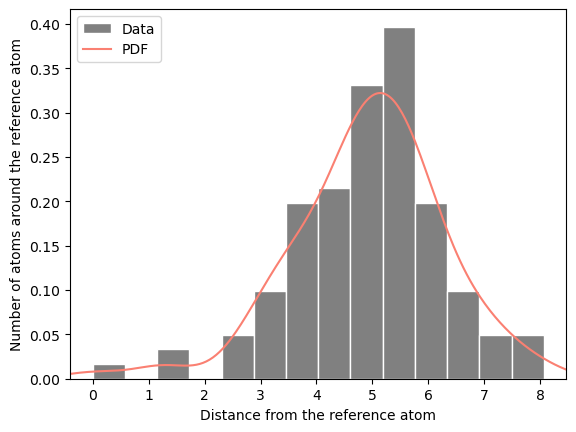

In [6]:
q25, q75 = np.percentile(distance[0], [25, 75])
bin_width = 2 * (q75 - q25) * len(distance[0]) ** (-1/3)
bins = round((max(distance[0]) - min(distance[0])) / bin_width) #Freedman–Diaconis number of bins
plt.hist(distance[0], density=True, bins=bins, label="Data",
         color ='grey', edgecolor='white', align='mid')
plt.ylabel('Number of atoms around the reference atom')
plt.xlabel('Distance from the reference atom')
mn, mx = plt.xlim()
plt.xlim(mn, mx)
kde_xs = np.linspace(mn, mx, 300)
kde = st.gaussian_kde(distance[0])
plt.plot(kde_xs, kde.pdf(kde_xs), label="PDF", c="salmon")
plt.legend(loc="upper left");

In [7]:
total_distance = [0 for i in range(sum(number_of_atom))]
for frames in range(number_of_frames):
    total_distance = [sum(x) for x in zip(total_distance, distance[frames])]

avg_distance = [x/number_of_frames for x in total_distance]
    

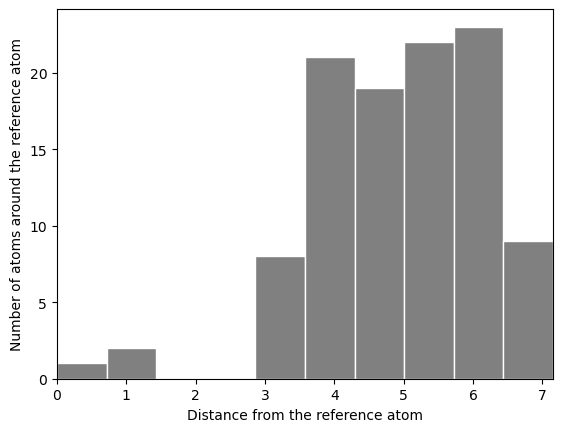

In [8]:
q25, q75 = np.percentile(avg_distance, [25, 75])
bin_width = 2 * (q75 - q25) * len(avg_distance) ** (-1/3)
bins = round((max(avg_distance) - min(avg_distance)) / bin_width) #Freedman–Diaconis number of bins
plt.hist(avg_distance, density=False, bins=bins, color ='grey',
         edgecolor='white', align='mid')
plt.ylabel('Number of atoms around the reference atom')
plt.xlabel('Distance from the reference atom')
plt.xlim(min(avg_distance), max(avg_distance));
#mn, mx = plt.xlim()
#plt.xlim(mn, mx);
#kde_xs = np.linspace(mn, mx, 300)
#kde = st.gaussian_kde(avg_distance)
#plt.plot(kde_xs, kde.pdf(kde_xs), label="PDF")
#plt.legend(loc="upper left");

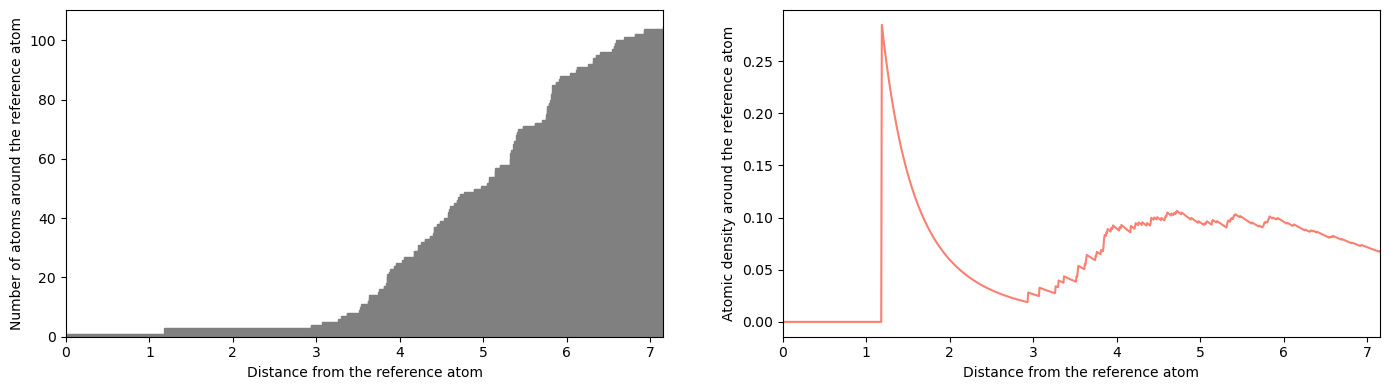

In [9]:
# Cummulative histogram and RDF
bins= 1000

fig = plt.figure(figsize=(14, 4))
fig = plt.subplot(1, 2, 1)
count, radial, bars = plt.hist(avg_distance, density=False, bins=bins, label="Data", 
                               cumulative=True, edgecolor='grey', align='mid' )
plt.ylabel('Number of atoms around the reference atom')
plt.xlabel('Distance from the reference atom')
plt.xlim(min(radial), max(radial))
#mn, mx = plt.xlim()
#kde_xs = np.linspace(mn, mx, 300)
#kde = st.gaussian_kde(avg_distance)
#plt.plot(kde_xs, kde.pdf(kde_xs), label="PDF")
#plt.legend(loc="upper left");

volume = [(4*math.pi*(x**3))/3 for x in radial[1:]]
density = (count-1)/volume
fig = plt.subplot(1, 2, 2)
plt.plot(radial[1:], density, c = 'salmon')
plt.ylabel('Atomic density around the reference atom')
plt.xlabel('Distance from the reference atom');
plt.xlim(min(radial), max(radial))

plt.tight_layout()
plt.subplots_adjust(wspace=0.2)